# Caso de Negocio

`completar` 

# Análisis Exploratorio de Datos

## Importar, Instalar y Cargar

### Instalación de librerías 


Para mantener los entornos actualizados, se almacenan las librerías necesarias en un archivo de requerimientos. Para instalar las librerías necesarias, se ejecuta el siguiente comando:

```bash
# Creación de archivo de requerimientos
pip freeze > requirements.txt
```

```bash
# Instalación de librerías necesarias
pip install -r requirements.txt
```

### Importar librerías

In [4]:
%pip install scikit-image --quiet

Note: you may need to restart the kernel to use updated packages.


In [5]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage import io, img_as_float
from scipy.ndimage import median_filter
import numpy as np

### Cargar Las Imagenes

In [6]:
image_directory = "base"
images = []

for filename in os.listdir(image_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img = Image.open(os.path.join(image_directory, filename))
        images.append((filename, img))

### Cargar Bounding Boxes

In [7]:
with open('classificationDownload/classifications.json', 'r') as file:
    bounding_boxes = json.load(file)   

## Visualización de Datos

### Visualización bounding boxes

In [8]:
# Función para dibujar las bounding boxes con etiquetas centradas
def draw_bounding_boxes(image_name, img, classifications):
    fig, ax = plt.subplots(1, figsize=(10, 7))
    ax.imshow(img)
    
    for classification in classifications:
        x_center = classification['nucleus_x']
        y_center = classification['nucleus_y']
        bethesda_system = classification['bethesda_system']
        cell_id = classification['cell_id']
        
        # Tamaño del rectángulo ajustado
        rect_width, rect_height = 50, 50  # Puedes ajustar estos valores según sea necesario
        
        # Calcular la esquina superior izquierda para centrar el rectángulo
        x = x_center - rect_width / 2
        y = y_center - rect_height / 2
        
        rect = plt.Rectangle((x, y), rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
        
        # Dibujar el rectángulo
        ax.add_patch(rect)
        
        # Agregar texto (bethesda_system y cell_id)
        label = f"ID: {cell_id}, System: {bethesda_system}"
        ax.text(x, y - 10, label, color='yellow', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.title(f"Image: {image_name}")
    plt.show()

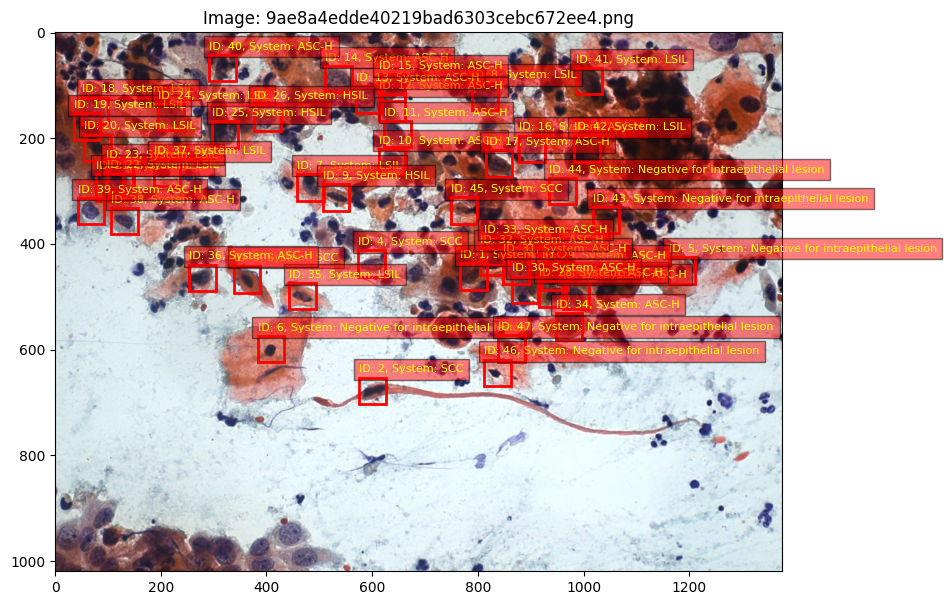

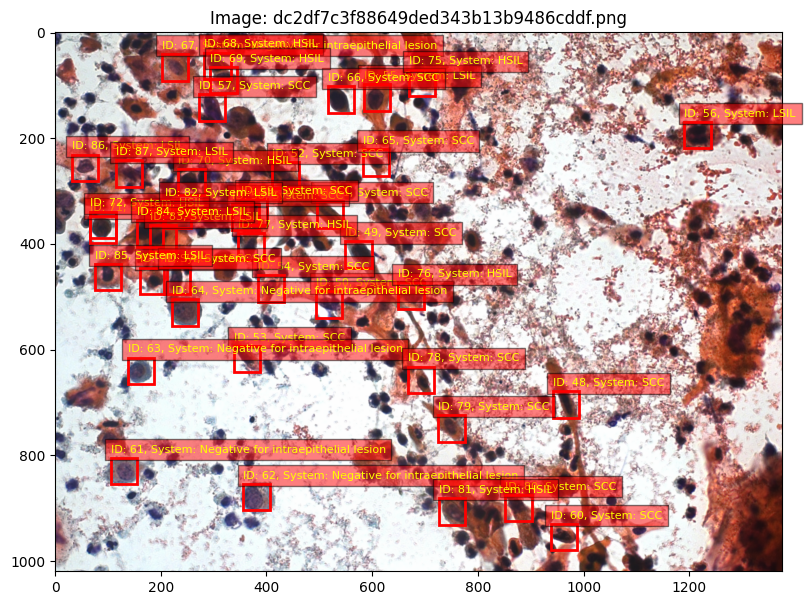

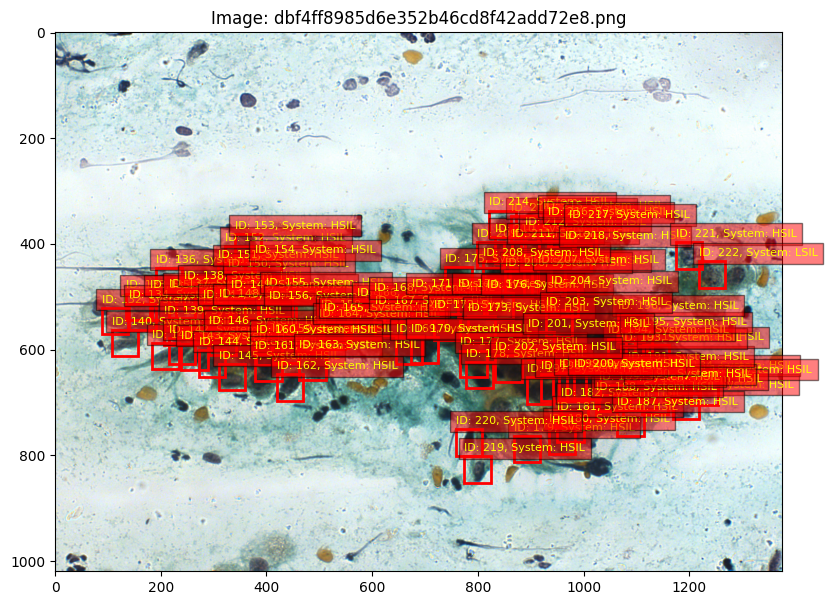

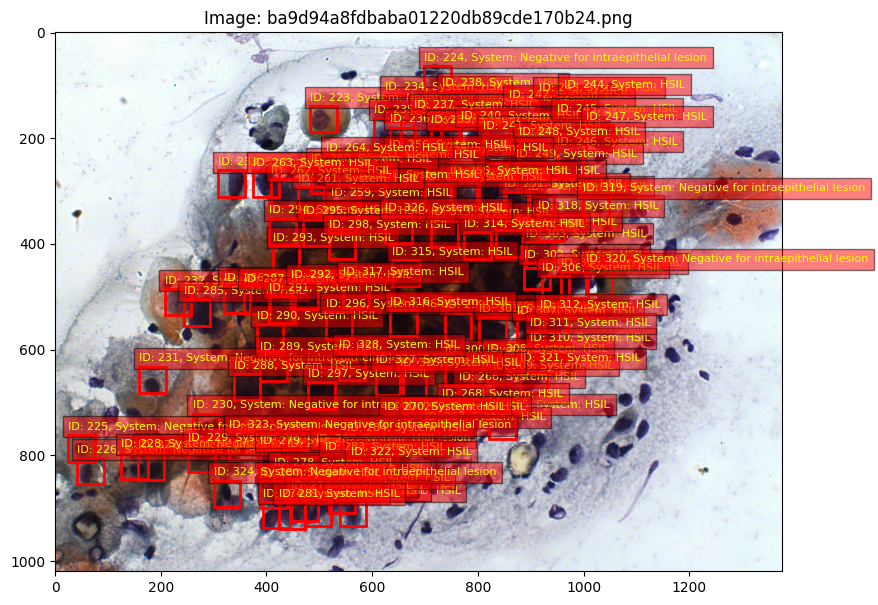

In [9]:
# Limitar a una muestra de 5 imágenes
sample_size = 5
count = 0

# Recorrer las entradas del JSON y visualizar cada imagen con sus bounding boxes
for entry in bounding_boxes:
    image_name = entry['image_name']
    classifications = entry['classifications']
    
    # Buscar y cargar la imagen correspondiente
    image_path = os.path.join(image_directory, image_name)
    
    if os.path.exists(image_path):
        img = Image.open(image_path)
        draw_bounding_boxes(image_name, img, classifications)
        count += 1
        if count == sample_size:
            break
    else:
        print(f"Imagen {image_name} no encontrada en {image_directory}")

A simple vista se puede ver que las celulas sanas son aquellas que no tienen fondo de color. 
Se podría buscar eliminar de las imagenes aquellos nucleos que tengan celulas sanas como pre-procesamiento.

** bounding boxes con colores para cada clase. modificarlo para que funcione para la imagen normal.**

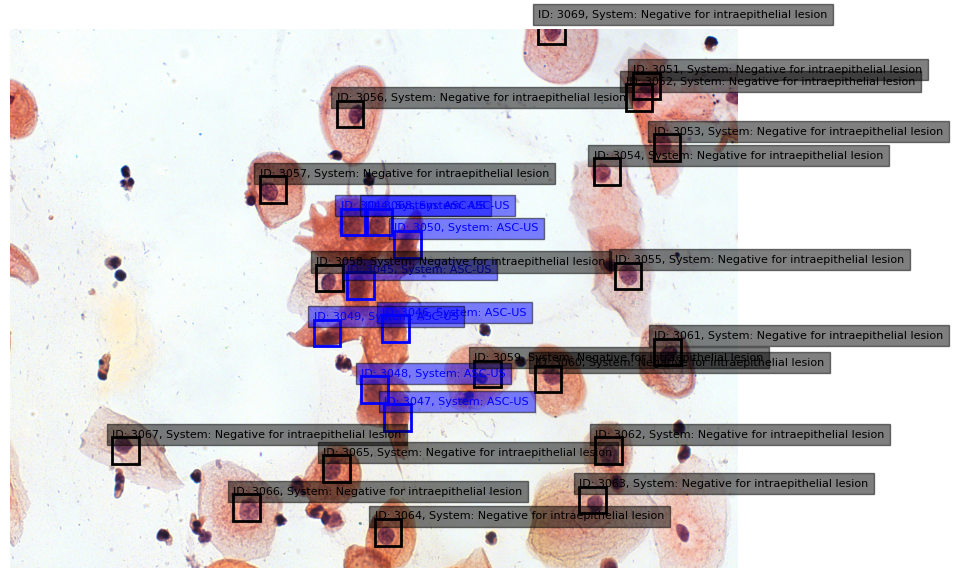

In [28]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image  # Necesitamos importar PIL para cargar la imagen correctamente

# Paso 1: Cargar las coordenadas desde el archivo JSON
with open('classificationDownload/classifications.json', 'r') as file:
    bounding_boxes_data = json.load(file)

# Definir un diccionario de colores para las diferentes clases (bethesda_system)
colors = {
    'SCC': 'red',
    'ASC-US': 'blue',
    'LSIL': 'green',
    'HSIL': 'purple',
    'AGC': 'orange',
    'Negative for intraepithelial lesion': 'black',
    # Agrega más clases y colores según sea necesario
}

# Paso 2: Definir la función para dibujar las bounding boxes en la imagen aislada
def draw_bounding_boxes(img, classifications):
    fig, ax = plt.subplots(1, figsize=(10, 7))
    ax.imshow(img)
    
    for classification in classifications:
        x_center = classification['nucleus_x']
        y_center = classification['nucleus_y']
        bethesda_system = classification['bethesda_system']
        cell_id = classification['cell_id']
        
        # Tamaño del rectángulo ajustado
        rect_width, rect_height = 50, 50  # Puedes ajustar estos valores según sea necesario
        
        # Calcular la esquina superior izquierda para centrar el rectángulo
        x = x_center - rect_width / 2
        y = y_center - rect_height / 2
        
        # Seleccionar el color correspondiente a la clase bethesda_system
        color = colors.get(bethesda_system, 'yellow')  # Usa yellow si la clase no está en el diccionario
        
        rect = plt.Rectangle((x, y), rect_width, rect_height, linewidth=2, edgecolor=color, facecolor='none')
        
        # Dibujar el rectángulo
        ax.add_patch(rect)
        
        # Agregar texto (bethesda_system y cell_id)
        label = f"ID: {cell_id}, System: {bethesda_system}"
        ax.text(x, y - 10, label, color=color, fontsize=8, bbox=dict(facecolor=color, alpha=0.5))

    plt.axis('off')
    plt.show()

# Paso 3: Filtrar las entradas del JSON para la imagen específica
image_name = '00b1e59ebc3e7be500ef7548207d44e2.png'

# Cargar la imagen utilizando PIL y convertirla en un array de NumPy
image_path = 'base/' + image_name  # Asegúrate de que la ruta a la imagen es correcta
image_test = np.array(Image.open(image_path))

for entry in bounding_boxes_data:
    if entry['image_name'] == image_name:
        classifications = entry['classifications']
        
        # Dibujar los bounding boxes en la imagen aislada
        draw_bounding_boxes(image_test, classifications)
        break  # Detener el loop después de dibujar los bounding boxes para esta imagen específica

## Análisis de Datos

### Segmentación y Detección de Bounding Boxes Precisas para Células

**Paso 1: Preprocesamiento de la Imagen**

In [11]:
def preprocess_image(image):
    # Convertir la imagen de PIL a array de NumPy
    img_np = np.array(image)
    
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Aplicar un filtro Gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Operación morfológica de apertura para eliminar el ruido
    kernel = np.ones((3,3), np.uint8)
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Mostrar la imagen preprocesada
    plt.figure()
    plt.imshow(morph_image, cmap='gray')
    plt.title('Imagen Preprocesada (Blureo + Operaciones Morfológicas)')
    plt.show()
    
    return morph_image

**Paso 2: Clustering con K-Means**

In [12]:
def preprocess_image(image):
    # Convertir la imagen de PIL a array de NumPy
    img_np = np.array(image)
    
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Aplicar un filtro Gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Operación morfológica de apertura para eliminar el ruido
    kernel = np.ones((3,3), np.uint8)
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return morph_image

def kmeans_clustering(image, k=3):
    # Reestructurar la imagen a un array 2D de píxeles
    pixel_values = image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    
    # Definir los criterios de K-means (10 iteraciones, precisión de 1.0)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Aplicar K-means
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convertir los centros de los clusters de nuevo a escala de grises
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    
    # Reestructurar la imagen segmentada a las dimensiones originales
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image, labels.reshape(image.shape)

def visualize_side_by_side(original_image, preprocessed_image, segmented_image):
    # Crear una figura con tres subplots, uno para la imagen original, otro para la preprocesada, y otro para la segmentada
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Mostrar la imagen original
    axes[0].imshow(original_image)
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')
    
    # Mostrar la imagen preprocesada
    axes[1].imshow(preprocessed_image, cmap='gray')
    axes[1].set_title("Imagen Preprocesada")
    axes[1].axis('off')
    
    # Mostrar la imagen segmentada utilizando los valores de los centroides
    axes[2].imshow(segmented_image, cmap='gray')
    axes[2].set_title("Imagen Segmentada con K-Means (Centroides)")
    axes[2].axis('off')
    
    # Mostrar la figura completa
    plt.show()

# Ejemplo de uso con la imagen específica que cargaste
image_name = '00b1e59ebc3e7be500ef7548207d44e2.png'
image_path = 'base/00b1e59ebc3e7be500ef7548207d44e2.png'
img = Image.open(image_path)

# Paso 1: Preprocesar la imagen
preprocessed_image = preprocess_image(img)

# Paso 2: Aplicar clustering con K-Means
segmented_image, labels = kmeans_clustering(preprocessed_image, k=6)

# Visualizar las imágenes lado a lado
visualize_side_by_side(img, preprocessed_image, segmented_image)

Centroides: [122 245  76 158 187 214]
Cluster menos saturado seleccionado: 2


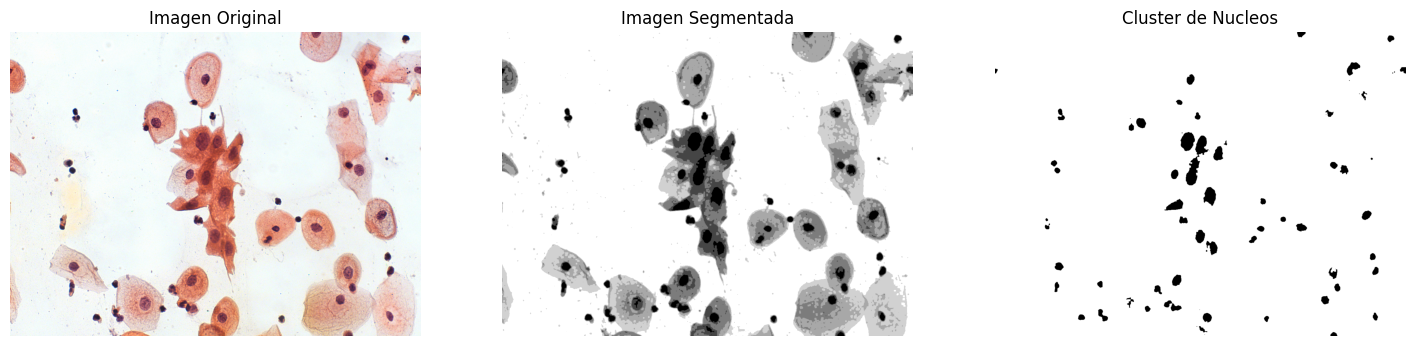

In [13]:
def preprocess_image(image):
    # Convertir la imagen de PIL a array de NumPy
    img_np = np.array(image)
    
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Aplicar un filtro Gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Operación morfológica de apertura para eliminar el ruido
    kernel = np.ones((3,3), np.uint8)
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return morph_image

def kmeans_clustering(image, k=6):
    # Reestructurar la imagen a un array 2D de píxeles
    pixel_values = image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    
    # Definir los criterios de K-means (10 iteraciones, precisión de 1.0)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Aplicar K-means
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convertir los centros de los clusters de nuevo a escala de grises
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    
    # Reestructurar la imagen segmentada a las dimensiones originales
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image, labels.reshape(image.shape), centers

def isolate_least_saturated_cluster(segmented_image, labels, centers):
    # Identificar el centroide más bajo (menos saturado)
    least_saturated_cluster = np.argmin(centers)
    
    # Verificación: Imprimir los valores de los centroides y el cluster seleccionado
    print("Centroides:", centers.flatten())
    print("Cluster menos saturado seleccionado:", least_saturated_cluster)
    
    # Crear una máscara binaria donde el cluster seleccionado es blanco (255) y el resto negro (0)
    mask = (labels == least_saturated_cluster).astype(np.uint8) * 255
    
    # Invertir la máscara para que el cluster seleccionado sea negro (0) y lo demás sea blanco (255)
    isolated_image = cv2.bitwise_not(mask)
    
    return isolated_image

def visualize_images(original_image, segmented_image, isolated_image):
    # Crear una figura con tres subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Mostrar la imagen original
    axes[0].imshow(original_image)
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')
    
    # Mostrar la imagen segmentada
    axes[1].imshow(segmented_image, cmap='gray')
    axes[1].set_title("Imagen Segmentada")
    axes[1].axis('off')
    
    # Mostrar la imagen con el cluster menos saturado en negro
    axes[2].imshow(isolated_image, cmap='gray')
    axes[2].set_title("Cluster de Nucleos")
    axes[2].axis('off')
    
    # Mostrar la figura completa
    plt.show()

# Ejemplo de uso con la imagen específica que cargaste
image_name = '00b1e59ebc3e7be500ef7548207d44e2.png'
image_path = 'base/00b1e59ebc3e7be500ef7548207d44e2.png'
img = Image.open(image_path)

# Paso 1: Preprocesar la imagen
preprocessed_image = preprocess_image(img)

# Paso 2: Aplicar clustering con K-Means
segmented_image, labels, centers = kmeans_clustering(preprocessed_image, k=6)

# Paso 3: Aislar el cluster menos saturado y mostrarlo en negro
isolated_image = isolate_least_saturated_cluster(segmented_image, labels, centers)

# Paso 4: Visualizar las imágenes
visualize_images(img, segmented_image, isolated_image)

In [21]:
# Asegúrate de que `img_np` es la imagen en formato NumPy, no el nombre de la imagen
img_np = np.array(img)  # Si `img` es la imagen PIL cargada, convertimos a NumPy

# Paso 1: Utiliza la función existente para obtener el cluster menos saturado
isolated_image_mask = isolate_least_saturated_cluster(img_np, labels, centers)

# Paso 2: Convertir la imagen en blanco y negro en una máscara binaria
mask = (isolated_image_mask == 0).astype(np.uint8)

# Paso 3: Crear una imagen en blanco del mismo tamaño que la original
colored_isolated_image = np.ones_like(img_np) * 255

# Paso 4: Aplicar la máscara a la imagen original para mantener solo los colores del cluster menos saturado
colored_isolated_image[mask == 1] = img_np[mask == 1]

# Paso 5: Visualizar la imagen con el cluster menos saturado y colores originales
plt.figure(figsize=(6, 6))
plt.imshow(colored_isolated_image)
plt.title("Cluster de Nucleos con Colores Originales")
plt.axis('off')
plt.show()

Centroides: [122 245  76 158 187 214]
Cluster menos saturado seleccionado: 2


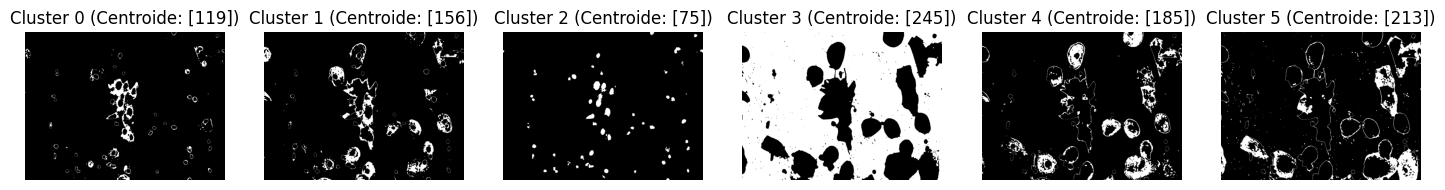

In [22]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

def preprocess_image(image):
    # Convertir la imagen de PIL a array de NumPy
    img_np = np.array(image)
    
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Aplicar un filtro Gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Operación morfológica de apertura para eliminar el ruido
    kernel = np.ones((3,3), np.uint8)
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return morph_image

def kmeans_clustering(image, k=6):
    # Reestructurar la imagen a un array 2D de píxeles
    pixel_values = image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    
    # Definir los criterios de K-means (10 iteraciones, precisión de 1.0)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Aplicar K-means
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convertir los centros de los clusters de nuevo a escala de grises
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    
    # Reestructurar la imagen segmentada a las dimensiones originales
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image, labels.reshape(image.shape), centers

def visualize_clusters_separately(segmented_image, labels, centers):
    k = len(centers)
    fig, axes = plt.subplots(1, k, figsize=(18, 6))
    
    for i in range(k):
        # Crear una máscara para el cluster i
        mask = (labels == i).astype(np.uint8) * 255
        
        # Aplicar la máscara a la imagen segmentada para visualizar solo el cluster i
        isolated_image = cv2.bitwise_and(segmented_image, segmented_image, mask=mask)
        
        # Mostrar el cluster i
        axes[i].imshow(isolated_image, cmap='gray')
        axes[i].set_title(f"Cluster {i} (Centroide: {centers[i]})")
        axes[i].axis('off')
    
    plt.show()

# Ejemplo de uso con la imagen específica que cargaste
image_name = '00b1e59ebc3e7be500ef7548207d44e2.png'
image_path = 'base/00b1e59ebc3e7be500ef7548207d44e2.png'
img = Image.open(image_path)

# Paso 1: Preprocesar la imagen
preprocessed_image = preprocess_image(img)

# Paso 2: Aplicar clustering con K-Means
segmented_image, labels, centers = kmeans_clustering(preprocessed_image, k=6)

# Paso 3: Visualizar cada cluster por separado
visualize_clusters_separately(segmented_image, labels, centers)


# Bibliografía